### Load In

In [1]:
''' Make sure you have pandorasim installed and updated '''
# pandorasim, Version: 1.0.10
# pandorasat, Version: 0.5.22

import pandorasat as ps
import pandorasim as pp
ps.utils.get_phoenix_model(teff=7000, jmag=10) # this is a temporary fix to an import error with pandorasim
from pandorasim import VisibleSim, NIRSim
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, Longitude
from astropy.io import fits
from pandorasat.plotting import animate
from pandorasat.plotting import save_mp4, save_gif
from astropy.time import Time, TimeDelta

### Importing additional functions and constants used in this notebook
import sys, os
sys.path.append(os.path.abspath('..'))
from CommissFunctions import generate_task_plan 
from CommissFunctions import data_rate, bits_per_pix_VIS, compression_fractor_VIS, frame_time_VIS, stored_frames_per_int_VIS, pass_time_min, VIS_ra_shape, VIS_dec_shape


/Users/lindseywiser/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
''' Define a PandoraSat object for calling constants '''
p = ps.PandoraSat()

# Define Array Location Function

In [3]:
''' Function defining the pattern of the target location on the array '''
### This function returns a location to point the telescope [in degrees] given an observation id number.
# We will update this function to adjust the pattern based on input from the stakeholders.
# We currently assume that the "home" location is with one of our two targets in the center. 
# (ra, dec)=(10,10) is only a default for visualization in the next cell.
###

def array_location(obsid_num, ra_home=10*u.degree, dec_home=10*u.degree):
    
    ra_home = ra_home
    dec_home = dec_home
    VIS_shape_deg = VIS_ra_shape.to(u.degree) ### we need the shape of the array in degrees. RA and Dec are the same.
    
    ### center 
    if obsid_num == 0: location = (ra_home, dec_home)
    
    ### ring 1
    offset1 = VIS_shape_deg *0.15  ### 15% movement
    if obsid_num == 1: location = (ra_home-offset1, dec_home)
    if obsid_num == 2: location = (ra_home, dec_home+offset1)
    if obsid_num == 3: location = (ra_home+offset1, dec_home)
    if obsid_num == 4: location = (ra_home, dec_home-offset1)
    
    ### ring 2
    offset2 = VIS_shape_deg *0.3  ### 30% movement
    offset3 = VIS_shape_deg *0.4  ### 40% movement
    if obsid_num == 5: location = (ra_home-offset3, dec_home)
    if obsid_num == 6: location = (ra_home-offset2, dec_home+offset2)
    if obsid_num == 7: location = (ra_home, dec_home+offset3)
    if obsid_num == 8: location = (ra_home+offset2, dec_home+offset2) 
    if obsid_num == 9: location = (ra_home+offset3, dec_home)
    if obsid_num == 10: location = (ra_home+offset2, dec_home-offset2)
    if obsid_num == 11: location = (ra_home, dec_home-offset3)
    if obsid_num == 12: location = (ra_home-offset2, dec_home-offset2)
    
    new_ra = location[0]
    new_dec = location[1]
    return (new_ra, new_dec)

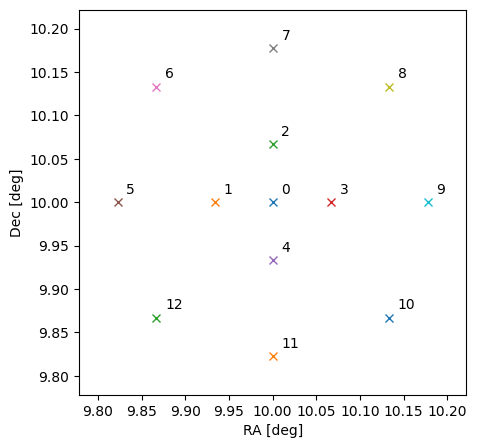

In [4]:
''' Plot the array location pattern on the VISDA array '''
### This is for visualizing the patern, only. (10,10) is a default central location. See function above. 

plt.figure(figsize=(5, 5))
ax = plt.subplot()

num_observations = 13
for i in range(num_observations):
    loc = array_location(i) ### call the dither() function above
    ax.plot(loc[0].value,loc[1].value, 'x')
    ax.annotate(str(i), (loc[0].value+0.01,loc[1].value+0.01))

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

VIS_shape_deg = VIS_ra_shape.to(u.degree) ### set plot limits to the shape of VISDA
plt.xlim(10-(VIS_shape_deg.value/2), 10+(VIS_shape_deg.value/2))
plt.ylim(10-(VIS_shape_deg.value/2), 10+(VIS_shape_deg.value/2))

plt.show()

# The rest of this notebook should be run for each of the 13 observations. Select an observation number

In [5]:
''' Only 0 runs right now. There is an open GitHub issue open to help resolve this. '''
observation_number = 0 

# Data Volume

Here, we estimate data volume based on obseravtion parameters and estimated rates and sizes. Currently, we're storing data volume constants in CommissFunctions.py, but we my want to store those elsewhere where everyone can reference the most recent numbers.

In [6]:
''' this sets observing parameters for activity '''
VIS_xpix              = 200 ### saving two 200x200 regions
VIS_ypix              = 200 
regions               = 2  
frames_per_int        = 1
num_int               = 600 

''' Calculating data volumes -- for 1 observation, i.e., 1 array location'''
int_and_reset_time    = frame_time_VIS * frames_per_int
bits_per_int          = VIS_xpix * VIS_ypix * regions * bits_per_pix_VIS * stored_frames_per_int_VIS
bits_per_sec          = bits_per_int / int_and_reset_time
test_time             = num_int * int_and_reset_time ### seconds
bits_per_sec_comp     = bits_per_sec / compression_fractor_VIS
bits_test_total       = bits_per_sec_comp * test_time
Gbits_test_packet     = bits_test_total / 1E9 * 1.1 * 1.25
downlinks             = Gbits_test_packet * 1E9 / (data_rate * 1E6) /60 /pass_time_min

print('test time, one observation:', test_time/60, 'minutes')
print(Gbits_test_packet, 'Gbits')
print(downlinks, 'downlinks')

print('.')
print('.')
print('.')

print('test time, total (not accounting for slew time):', test_time*num_observations/60, 'minutes')
print('downlinks, total:', downlinks*num_observations)

test time, one observation: 2.0 minutes
0.7040000000000001 Gbits
0.29333333333333333 downlinks
.
.
.
test time, total (not accounting for slew time): 26.0 minutes
downlinks, total: 3.8133333333333335


# Define Targets

For now, we select an arbitrary primary target. The secondary target is selected by pandorasim and is the next brightest object in frame. A list of possible targets is being made (check with Aisha Iyer or Lindsey Wiser for updates).  

In [7]:
### Posible Targets:
# ...
# ...
# ...
# ...

In [8]:
''' Finds target coordinates based on astropy '''
### You can do this differently as long as you have DEC and RA
### Pick one of the two targets to serve as the "primary." This places it at the center in observation 0.
target = "GJ 3470"
c = SkyCoord.from_name(target)


''' Identify the start time and end time of the observation '''
start_time = Time.now() # starting now
time_delta = TimeDelta(test_time, format='sec')
end_time = start_time + time_delta


''' Initialize a simulator object '''
### Set the number of ROIs and their sizes
sim = VisibleSim(ROI_size=(VIS_xpix, VIS_ypix), nROIs=regions) 

Output()

In [9]:
''' Define the center of our observation based on primary target location and observation number '''
location = array_location(observation_number, c.ra, c.dec)
ra0      = location[0] 
dec0     = location[1] 
theta0   = 0*u.deg ### theta is currently arbitrary 


''' Point the simulator to the corrected location '''
###        RA,   DEC,    Theta 
sim.point(ra0, dec0, -40*u.deg)

Output()

Output()

Output()

In [10]:
''' sim has various attributes you can print out '''
#print(sim.ra, sim.dec, sim.wcs)


''' Notably we have a Catalog of objects visable in the VIS FOV '''
cat = sim.source_catalog
#print(cat)

In [11]:
''' identify the correct ROIs based on pixel locations of our two targets '''
### This will set the ROI locations given an observation number and our two targets. 
# By default, one ROI is at the center and the second is centered at the next brightest target.
# We instead want to define our own locations. This is in progress. 
###

''' THIS DOES NOT WORK YET. For now, we can just produce observation 0 with a default second target. '''

if observation_number>0: 
    for i in range(len(cat)):
        ### search the catalog for a match. Coordinates are not exact, so we round to 2 decimals.
        if round(c.ra.value,2)==round(cat.ra[i],2) and round(c.dec.value,2)==round(cat.dec[i],2):
            print('Match! Cat index: ', i)
            #print(c.ra.value, cat.ra[i])
            #print(c.dec.value, cat.dec[i])
            cat_index = i
    
    ### set corner of primary ROI  
    sim.ROI_corners[0] = (cat.row[cat_index]-(VIS_xpix/2), cat.column[cat_index]-(VIS_ypix/2)) 


print('ROI locations [pix]: ', sim.ROI_corners)


''' Save ROI locations in sky coordinates for later '''
### Once the above update is made, we may do this differently.
ROI0_coord = sim.pixel_to_world(sim.ROI_corners[0][0], sim.ROI_corners[0][1])
ROI1_coord = sim.pixel_to_world(sim.ROI_corners[1][0], sim.ROI_corners[1][1])

ROI locations [pix]:  [(924.0, 924.0), (628, 760)]


# Observation

<Axes: title={'center': 'VISDA\n(RA:119.77 deg, Dec:15.39 deg, Roll:-40.00 deg)'}, xlabel='Column [pixel]', ylabel='Row [pixel]'>

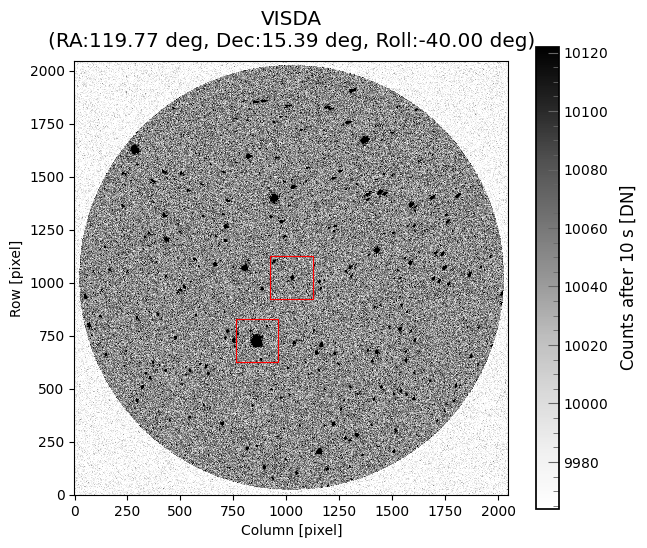

In [12]:
''' Plot the Full Frame Image. ROIs are in red boxes defining the subarray. '''
sim.show_FFI()

In [13]:
''' Create an Observation. '''
### This returns an astropy.io.fits.HDUList array. 
# `nreads` sets how many reads of the detector are coadded together to create a frame.
# `bin_frames` is a shortcut parameter to speed up computation. Must be a factor of nreads. We can ignore this for low nreads. 
# `nframes` sets how many frames will be returned.
# `start_time` indicates the time of observation. 
# `output_type` is set to array, for now. This make it easy to call, but we'll save it as a fits file later. 
###

data = sim.observe(nreads=frames_per_int, bin_frames=1, nframes=num_int, start_time=start_time, output_type="array")

### The shape is: (num ROIs, num frames, nrows, ncolumns)
data.shape

Modeling Pixel Positions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 11.32it/s]


(2, 600, 200, 200)

array([[<Axes: ylabel='Row\n[subarray pixel]'>, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

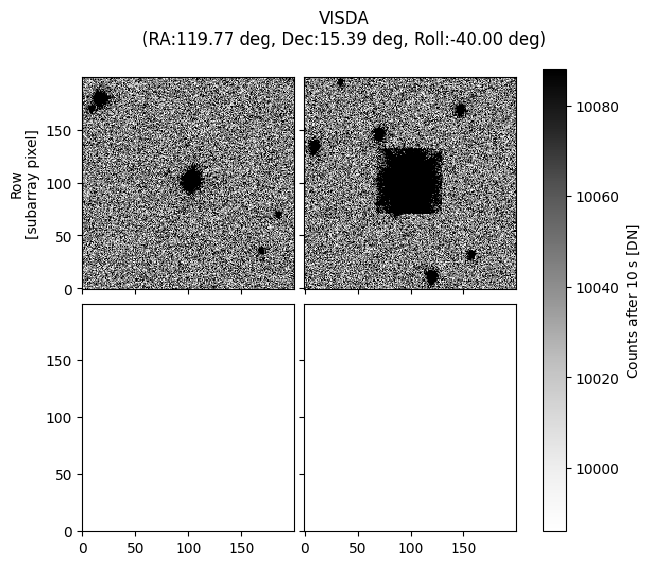

In [14]:
''' Plot our ROIs (regions of interest). ''' 
sim.show_ROI()

In [15]:
''' Plot animations of ROIs frame-to-frame. Adjust index to switch ROIs. ''' 
index = 0
animate(data[index])

### If you want to save this:
#save_mp4(data[index], "3_12_animation.mp4")
#save_gif(data[index], "3_12_animation.gif")

# Save the simulated observation

In [16]:
''' Re-Create the observation in the correct format for the .fits file (i.e., output_type set to default) '''
### Before, object_type was array for easy computation in this notebook, but that is not correct for the .fits file
hdulist = sim.observe(nreads=frames_per_int, nframes=num_int, bin_frames=1, start_time=start_time)


''' Save our simulated observation in a fits file '''
targ = target.replace(" ", "")
rois_outfile = "3.15_rois_"+str(targ)+"_obs"+str(observation_number)+".fits"
hdulist.writeto(rois_outfile, overwrite=True)

Modeling Pixel Positions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 13.37it/s]


In [17]:
### Show what is in our fits file: 
'''
Three FITS file extensions: 
    (1) PRIMARY: information about the simulated observation 
    (2) SCIENCE: data info, images
    (3) ROITABLE: VISDA pixel coordinates of the origin of the subarray, which is defined as the lower left corner
'''

hdul_rois = fits.open(rois_outfile)
print(hdul_rois.info())

#print('.')
#print('.')
#print('.')
#print('-- PRIMARY Headers --')
#print(hdul_rois[0].header)

#print('.')
#print('.')
#print('.')
#print('-- SCIENCE Headers --')
#print(hdul_rois[1].header)

#print('.')
#print('.')
#print('.')
#print('-- ROITABLE Headers --')
#print(hdul_rois[2].header)

Filename: 3.15_rois_GJ3470_obs0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  SCIENCE       1 ImageHDU        75   (400, 400, 600)   int64   
  2  ROITABLE      1 BinTableHDU     22   2R x 2C   [D, K]   
None


# Obs Data Product

### RD-B1: create a PSF shape data cube 

A datacube containing the expected Point Spread Function (PSF) 2D shape as a function of i) position on the detector ii) wavelength iii) temperature of the optics(?). This will be used by the pipeline to a) create simulated data and b) to identify optimal extraction apertures. This product may be built from models, and may be informed and validated by ground tests and commissioning tests.

Right now, we aren't including much here, but we can develop this further if it would be useful. 

In [18]:
''' Plot the ROIs from the fits file to compare to expected target locations '''

frame = 0 ### specify which integration to plot 
image = hdul_rois[1].data[frame]

### pixel numbers do not correlate with detector pixel numbers here.
#plt.imshow(image, cmap='binary', interpolation='nearest', extent=[0, VIS_xpix*2, 0, VIS_ypix*2])

#plt.xlabel('x pixel')
#plt.ylabel('y pixel')
#plt.title('Integration '+str(frame))

# Generate SOC File

In [19]:
'''Here we define the information required for scheduling the observation.'''
### Some variables may be removed/added/changed.

variables = {
    'visit_id': '0315', ### setting based on task number. Could change. 
    'obs_id': f"{observation_number:03}", ### setting based on dither number. 
    'target': target, 
    'priority': 1, 
    'start_time': start_time, 
    'stop_time': end_time, 
    'RA': c.ra,
    'DEC': c.dec, 
    'NIR_AvgGroups': '', ### no NIR. 
    'NIR_ROI_StartX': '', 
    'NIR_ROI_StartY': '', 
    'NIR_ROI_SizeX': '', 
    'NIR_ROI_SizeY': '',
    'NIR_SC_Resets1': '',
    'NIR_SC_Resets2': '', 
    'NIR_SC_DropFrames1': '',
    'NIR_SC_DropFrames2': '',
    'NIR_SC_DropFrames3': '', 
    'NIR_SC_ReadFrames': '',
    'NIR_targetID': '', 
    'NIR_SC_Groups': '',
    'NIR_SC_Integrations': '', 
    'VIS_StarRoiDetMethod': 0,  ### 0: monitor stars at positions defined in [PredefinedStarRoiRa, PredefinedStarRoiDec]. 1: Run star detection algorithm on first image and obtain star ROIs from results.
    'VIS_FramesPerCoadd': frames_per_int, 
    'VIS_NumTotalFramesRequested': num_int, 
    'VIS_TargetRA': c.ra, 
    'VIS_TargetDEC': c.dec, 
    'VIS_IncludeFieldSolnsInResp': 1, ### Determines whether the Ra/Dec/Rot values calculated for each frame in the visible science collect will be included in the response message [1] or not [0].
    'VIS_StarRoiDimension': [VIS_xpix, VIS_ypix], 
    'VIS_MaxNumStarRois': '', ### max number of star ROIs that will be used for coadding signal from target stars if StarRoiDetMethod == 1.
    'VIS_numPredefinedStarRois': regions, ### If StarRoiDetMethod==0, this is the number of [RA, DEC] coordinates contained in the PredefinedStarRoiRA and PredefinedStarRoiDEC vectors.
    'VIS_PredefinedStarRoiRa': [ROI0_coord[0], ROI1_coord[0]], ### currently defining as corner of ROI. We'll update this to be ROI centers.
    'VIS_PredefinedStarRoiDec': [ROI0_coord[1], ROI1_coord[1]], 
    'VIS_targetID': target, 
    'VIS_NumExposuresMax': num_int, 
    'VIS_ExposureTime_us': frame_time_VIS * 1000000  
}

In [20]:
'''Generate the SOC .xml file'''
### This may also change format

output_soc_file = variables['visit_id']+'_'+variables['obs_id']+'_SOC.xml' 
generate_task_plan(variables, output_soc_file)